# New_GT points preprocessing and testing

In [3]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import pickle
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [4]:
def fn_labels(row):
    sorted_idx = np.argsort(list(row[:-1]))
    ndvi_values = list(row[:-1])
    columns = ['oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'label']
    i = 0
    while 4 + i < len(sorted_idx) - 1:
        idx = sorted_idx[i]
        try:
            if ndvi_values[idx+1] < ndvi_values[idx+5]:
                return columns[idx]
            else:
                i += 1
        except:
            i += 1
            
def fn_encoding(row):
    if row == 'oct_2f':
        return 0
    elif row == 'nov_1f':
        return 1
    elif row == 'nov_2f':
        return 2
    elif row == 'dec_1f':
        return 3
    elif row == 'dec_2f':
        return 4
    return row

def new_GT_initial_preprocess():
    
    all_shp_fls = np.array(glob(r'data_files\krishna\**\*.shp', recursive=True))
    pol_shp_files = [files for files in all_shp_fls if 'point' not in files]
    pol_shp_files.remove(pol_shp_files[-2])

    series = pd.Series(gp.read_file(pol_shp_files[0]).columns)
    ndvi_cols = list(series[series.apply(lambda row : True if 'FN' in row else False)])
    
    columns = ['oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'label']
    
    tst_pol_wheat = pd.DataFrame(columns = columns)
    tst_pol_mustard = pd.DataFrame(columns = columns)

    for file in pol_shp_files:
        temp = gp.read_file(file)[ndvi_cols[1:11]]
        temp.columns = columns[:-1]
        # temp['district'] = 'SHIVPURI' * temp.shape[0]
        if 'Wheat' in file:
            temp['label'] = [1]*temp.shape[0]
            tst_pol_wheat = pd.concat([tst_pol_wheat, temp],ignore_index=True)
        else:
            temp['label'] = [5]*temp.shape[0]
            tst_pol_mustard = pd.concat([tst_pol_mustard, temp], ignore_index=True)
            
    tst_pol_wheat.iloc[:,:-1] = tst_pol_wheat.iloc[:,:-1].apply(lambda row:round(row*100+100))
    tst_pol_mustard.iloc[:,:-1] = tst_pol_mustard.iloc[:,:-1].apply(lambda row:round(row*100+100))
    
    tst_pol_wheat['label'] = tst_pol_wheat.iloc[:,:-1].apply(fn_labels, axis=1)

    tst_pol_wheat['label'] = tst_pol_wheat.label.apply(fn_encoding)

    tst_pol = pd.concat([tst_pol_wheat, tst_pol_mustard], ignore_index=True)
    
    tst_pol.dropna(inplace=True)
    
    return tst_pol

## Approach 1 - Imputing outliers

In [5]:
tst_pol = new_GT_initial_preprocess()

<Axes: >

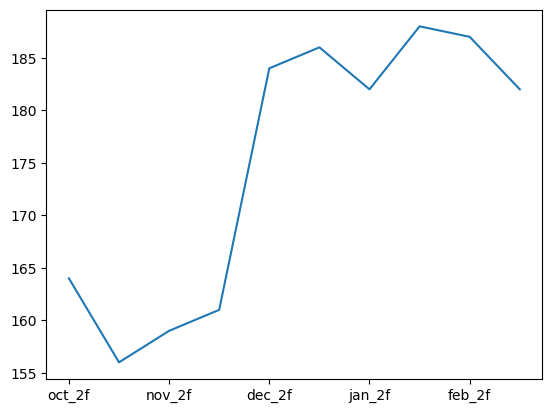

In [18]:
tst_pol.loc[2711][:-1].plot()

<Axes: >

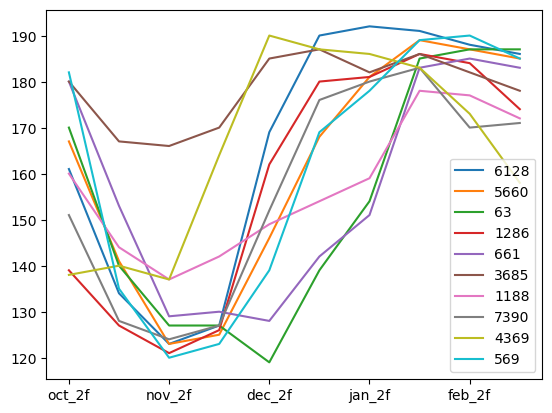

In [19]:
tst_pol[tst_pol.label == 2].iloc[:,:-1].sample(10, random_state=0).T.plot()

In [195]:
def outlier_imputation(group):
    group[(group < 100) | (group > 190)] = round(group.mean())
    return group

tst_pol.iloc[:,:-1] = tst_pol.groupby('label').transform(outlier_imputation)

In [196]:
X_tst_pol = tst_pol.drop('label', axis=1)
y_tst_pol = tst_pol['label']

scaler = pickle.load(open(r'models/Multiclass_StandardScaler_1.1', 'rb'))

X_tst_pol = pd.DataFrame(scaler.transform(X_tst_pol), columns=X_tst_pol.columns)

y_tst_pol = y_tst_pol.astype(int)

In [199]:
y_tst_pol.value_counts(normalize=True)

2    0.345040
1    0.321627
3    0.202631
5    0.097635
0    0.033068
Name: label, dtype: float64

In [172]:
from copy import deepcopy
from glob import glob

test_recall_scores = []
confusion_matrices = []
y_hat = []
test_dfs = []

model_paths = [path for path in glob('models\\**') if 'Mul' in path]

for path in model_paths[:-1]:
    
    strt_col, end_col = '_'.join(path.split('_')[1:-1]).split('-')
    temp_X_test = X_tst_pol.loc[:,strt_col:end_col]    
    model = pickle.load(open(path, 'rb'))
    test_pred = model.predict(temp_X_test)
    y_hat.append(pd.Series(test_pred))
    precision, recall, f1score, support = score(y_tst_pol, test_pred, labels=[0,1,2,3,4,5])
    test_recall_scores.append([recall[2], recall[-1]])
    confusion_matrices.append(pd.DataFrame(confusion_matrix(y_tst_pol, test_pred), 
                         columns=['Wheat-Oct_2f', 'Wheat-Nov_1f','Wheat-Nov_2f','Wheat-Dec_1f','Wheat-Dec_2f', 'Non_Wheat'], 
                         index=['Wheat-Oct_2f', 'Wheat-Nov_1f','Wheat-Nov_2f','Wheat-Dec_1f','Wheat-Dec_2f', 'Non_Wheat']))
    df = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df['correct_pred(%)'] = round(df['correct_pred']/df['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_Wheat-Oct_2f', 'incorr_Wheat-Nov_1f', 'incorr_Wheat-Nov_2f', 'incorr_Wheat-Dec_1f','incorr_Wheat-Dec_2f', 'incorr_Non_Wheat']
    df = pd.concat([df, temp_df], axis=1)
    test_dfs.append(df)
    
    print(recall)

[0.03649635 0.11181989 0.33193424 0.71530673 0.         0.8986403 ]
[0.03649635 0.11932458 0.33648129 0.39606909 0.         0.96415328]
[0.00364964 0.12870544 0.34802378 0.31149494 0.         0.9789864 ]
[0.         0.10093809 0.34592515 0.29660512 0.         0.9789864 ]
[0.02554745 0.16510319 0.3490731  0.3388922  0.         0.97033375]
[0.02189781 0.19549719 0.34837356 0.30315664 0.         0.9802225 ]
[0.         0.00337711 0.30989857 0.36628946 0.         0.98145859]


C:\Users\user\miniconda3\envs\kdss_base\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\miniconda3\envs\kdss_base\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\miniconda3\envs\kdss_base\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\miniconda3\envs\kdss

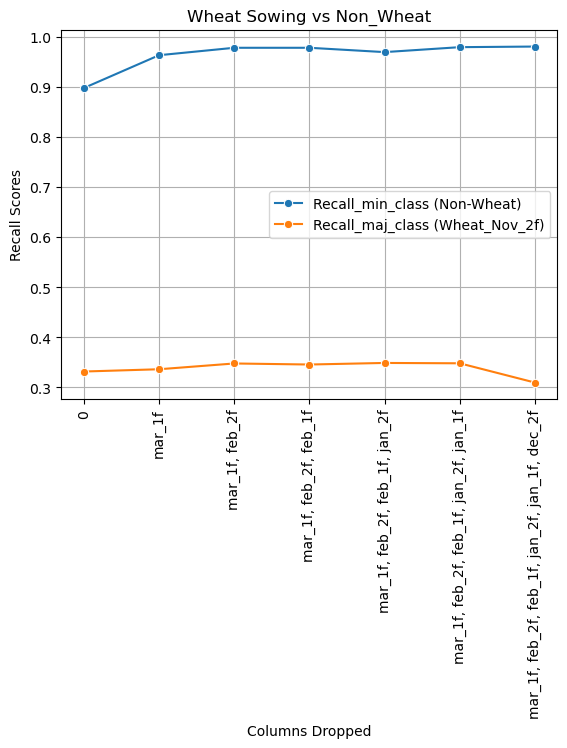

In [173]:
sns.lineplot(y=np.array(test_recall_scores)[:,1], 
             x=['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f'], 
             label='Recall_min_class (Non-Wheat)', marker="o")
sns.lineplot(y=np.array(test_recall_scores)[:,0], 
             x=['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f'], 
             label='Recall_maj_class (Wheat_Nov_2f)', marker="o")
plt.xlabel('Columns Dropped')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat Sowing vs Non_Wheat')
plt.grid()
plt.show()

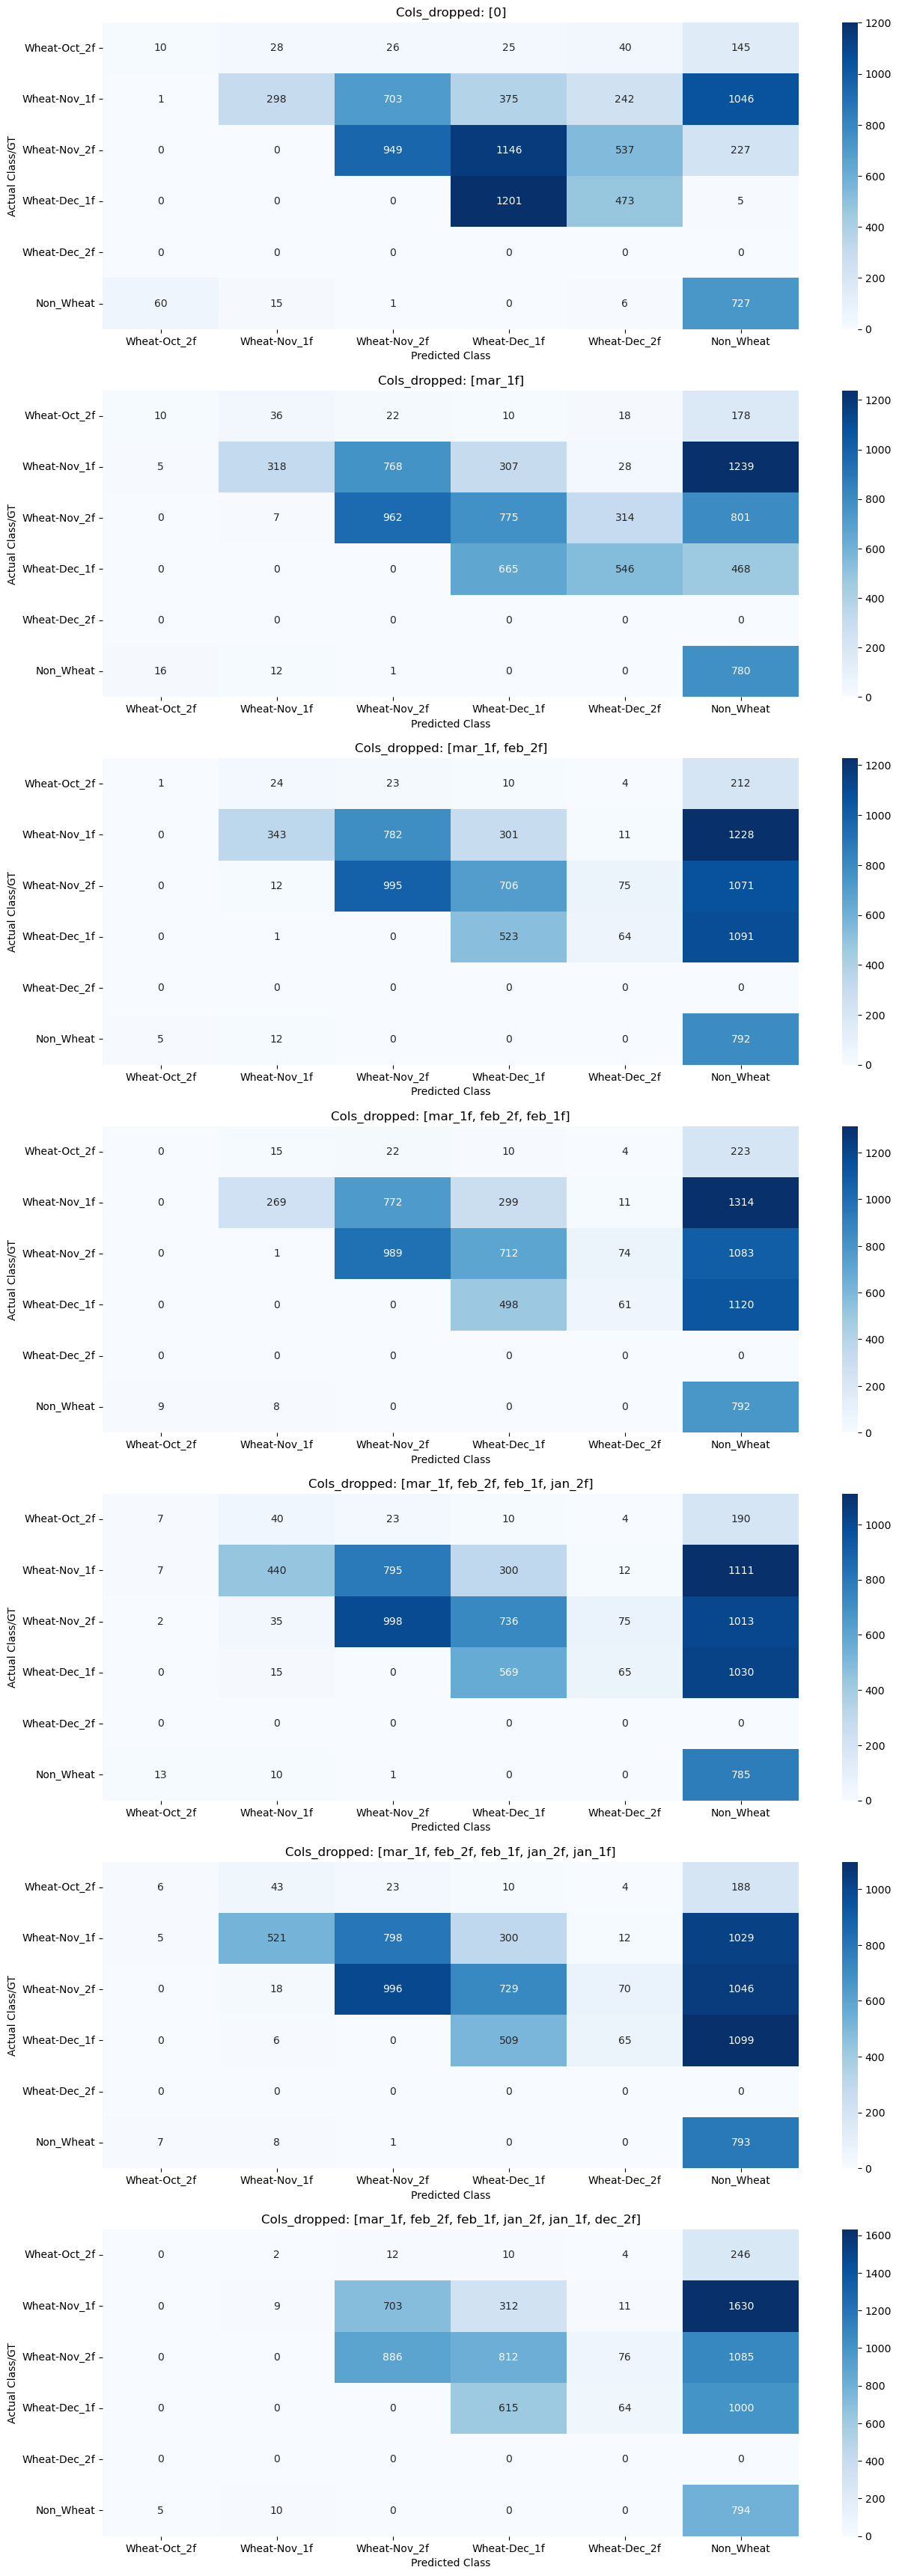

In [174]:
plt.figure(figsize=(15,50))
columns_dropped = ['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f']
for i in range(len(confusion_matrices)):
    plt.subplot(8,1,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Cols_dropped: [{columns_dropped[i]}]')
plt.show()

In [175]:
inter = set(tst_pol[(y_hat[0] & y_tst_pol) == 0].index)
for i in y_hat[1:]:
    inter = inter.intersection(set(tst_pol[(i & y_tst_pol) == 0].index))

C:\Users\user\AppData\Local\Temp\ipykernel_5616\2099886206.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inter = set(tst_pol[(y_hat[0] & y_tst_pol) == 0].index)
C:\Users\user\AppData\Local\Temp\ipykernel_5616\2099886206.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inter = inter.intersection(set(tst_pol[(i & y_tst_pol) == 0].index))
C:\Users\user\AppData\Local\Temp\ipykernel_5616\2099886206.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inter = inter.intersection(set(tst_pol[(i & y_tst_pol) == 0].index))
C:\Users\user\AppData\Local\Temp\ipykernel_5616\2099886206.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inter = inter.intersection(set(tst_pol[(i & y_tst_pol) == 0].index))
C:\Users\user\AppData\Local\Temp\ipykernel_5616\2099886206.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inter = inter.intersec

In [176]:
len(inter)

1668

C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ic = tst_pol[((y_hat[i] & y_tst_pol) == 0)]
C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corr = tst_pol[((y_hat[i] & y_tst_pol) == 1)]
C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ic = tst_pol[((y_hat[i] & y_tst_pol) == 0)]
C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corr = tst_pol[((y_hat[i] & y_tst_pol) == 1)]
C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ic = tst_pol[((y_hat[i] & y_tst_pol) == 0)]
C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py

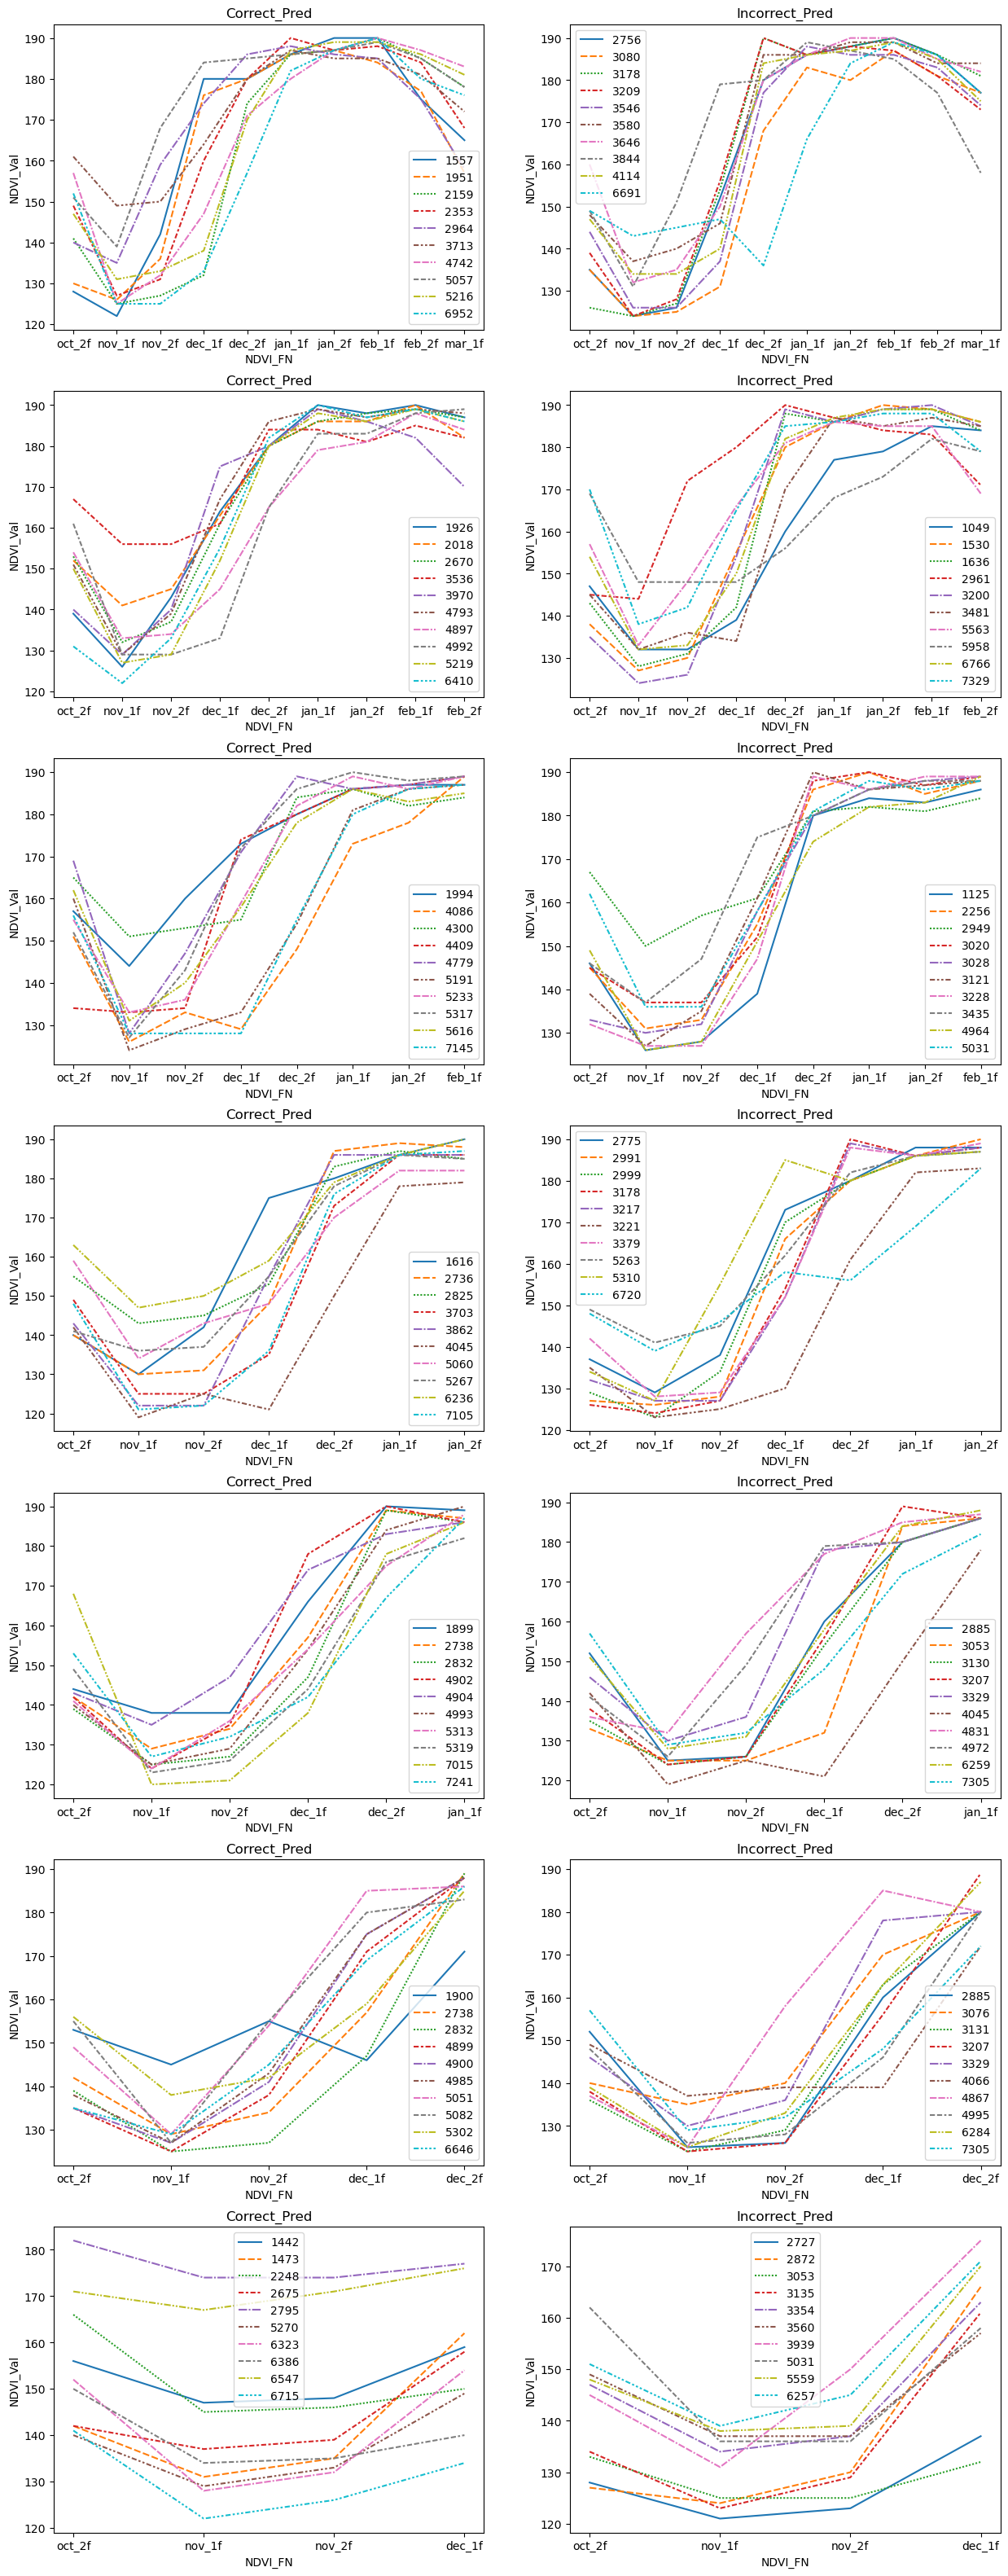

In [177]:
j = 1
plt.figure(figsize=(15,40))
for i in range(len(y_hat)):
    ic = tst_pol[((y_hat[i] & y_tst_pol) == 0)]
    corr = tst_pol[((y_hat[i] & y_tst_pol) == 1)]
    ic_ndvi_df = ic[ic.label == 1].sample(10, random_state=42).iloc[:,:-(i+1)]
    corr_ndvi_df = corr[corr.label == 1].sample(10, random_state=42).iloc[:,:-(i+1)]
    plt.subplot(7,2,j)
    sns.lineplot(corr_ndvi_df.T).set(title='Correct_Pred')
    plt.xlabel('NDVI_FN')
    plt.ylabel('NDVI_Val')
    plt.subplot(7,2,j+1)
    sns.lineplot(ic_ndvi_df.T).set(title='Incorrect_Pred')
    plt.xlabel('NDVI_FN')
    plt.ylabel('NDVI_Val')
    j += 2
plt.show()

#### Approach 2 - Removing outliers

In [178]:
tst_pol = new_GT_initial_preprocess()

In [179]:
outlier_indices = tst_pol[(tst_pol.iloc[:,:10].apply(lambda row : True if ((row < 100).sum() != 0) | ((row > 190).sum() != 0) else False, axis=1))].index

tst_pol.drop(outlier_indices, inplace=True)

In [180]:
X_tst_pol = tst_pol.drop('label', axis=1)
y_tst_pol = tst_pol['label']

scaler = pickle.load(open(r'models/Multiclass_StandardScaler_1.1', 'rb'))

X_tst_pol = pd.DataFrame(scaler.transform(X_tst_pol), columns=X_tst_pol.columns)

y_tst_pol = y_tst_pol.astype(int)

In [181]:
from copy import deepcopy
from glob import glob

test_recall_scores = []
confusion_matrices = []
y_hat = []

model_paths = [path for path in glob('models\\**') if 'Mul' in path]

for path in model_paths[:-1]:
    
    strt_col, end_col = '_'.join(path.split('_')[1:-1]).split('-')
    temp_X_test = X_tst_pol.loc[:,strt_col:end_col]    
    model = pickle.load(open(path, 'rb'))
    test_pred = model.predict(temp_X_test)
    y_hat.append(pd.Series(test_pred))
    precision, recall, f1score, support = score(y_tst_pol, test_pred, labels=[0,1,2,3,4,5])
    test_recall_scores.append([recall[2], recall[-1]])
    confusion_matrices.append(pd.DataFrame(confusion_matrix(y_tst_pol, test_pred), 
                         columns=['Wheat-Oct_2f', 'Wheat-Nov_1f','Wheat-Nov_2f','Wheat-Dec_1f','Wheat-Dec_2f', 'Non_Wheat'], 
                         index=['Wheat-Oct_2f', 'Wheat-Nov_1f','Wheat-Nov_2f','Wheat-Dec_1f','Wheat-Dec_2f', 'Non_Wheat']))
    df = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df['correct_pred(%)'] = round(df['correct_pred']/df['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_Wheat-Oct_2f', 'incorr_Wheat-Nov_1f', 'incorr_Wheat-Nov_2f', 'incorr_Wheat-Dec_1f','incorr_Wheat-Dec_2f', 'incorr_Non_Wheat']
    df = pd.concat([df, temp_df], axis=1)
    test_dfs.append(df)
    
    print(recall)

[0.03896104 0.0455814  0.28392774 0.71273713 0.         0.8989899 ]
[0.05194805 0.05302326 0.28346457 0.3902439  0.         0.96464646]
[0.         0.07348837 0.29365447 0.29607046 0.         0.97979798]
[0.         0.05023256 0.2890227  0.27777778 0.         0.97979798]
[0.06493506 0.09488372 0.29550718 0.32452575 0.         0.97348485]
[0.02597403 0.09767442 0.29319129 0.28455285 0.         0.98232323]
[0.         0.00186047 0.2704956  0.34078591 0.         0.98106061]


C:\Users\user\miniconda3\envs\kdss_base\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\miniconda3\envs\kdss_base\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\miniconda3\envs\kdss_base\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\miniconda3\envs\kdss

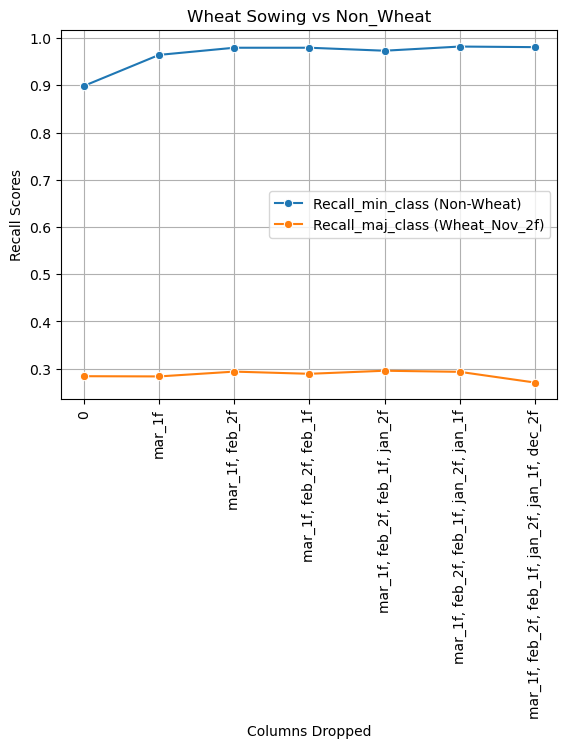

In [182]:
sns.lineplot(y=np.array(test_recall_scores)[:,1], 
             x=['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f'], 
             label='Recall_min_class (Non-Wheat)', marker="o")
sns.lineplot(y=np.array(test_recall_scores)[:,0], 
             x=['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f'], 
             label='Recall_maj_class (Wheat_Nov_2f)', marker="o")
plt.xlabel('Columns Dropped')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat Sowing vs Non_Wheat')
plt.grid()
plt.show()

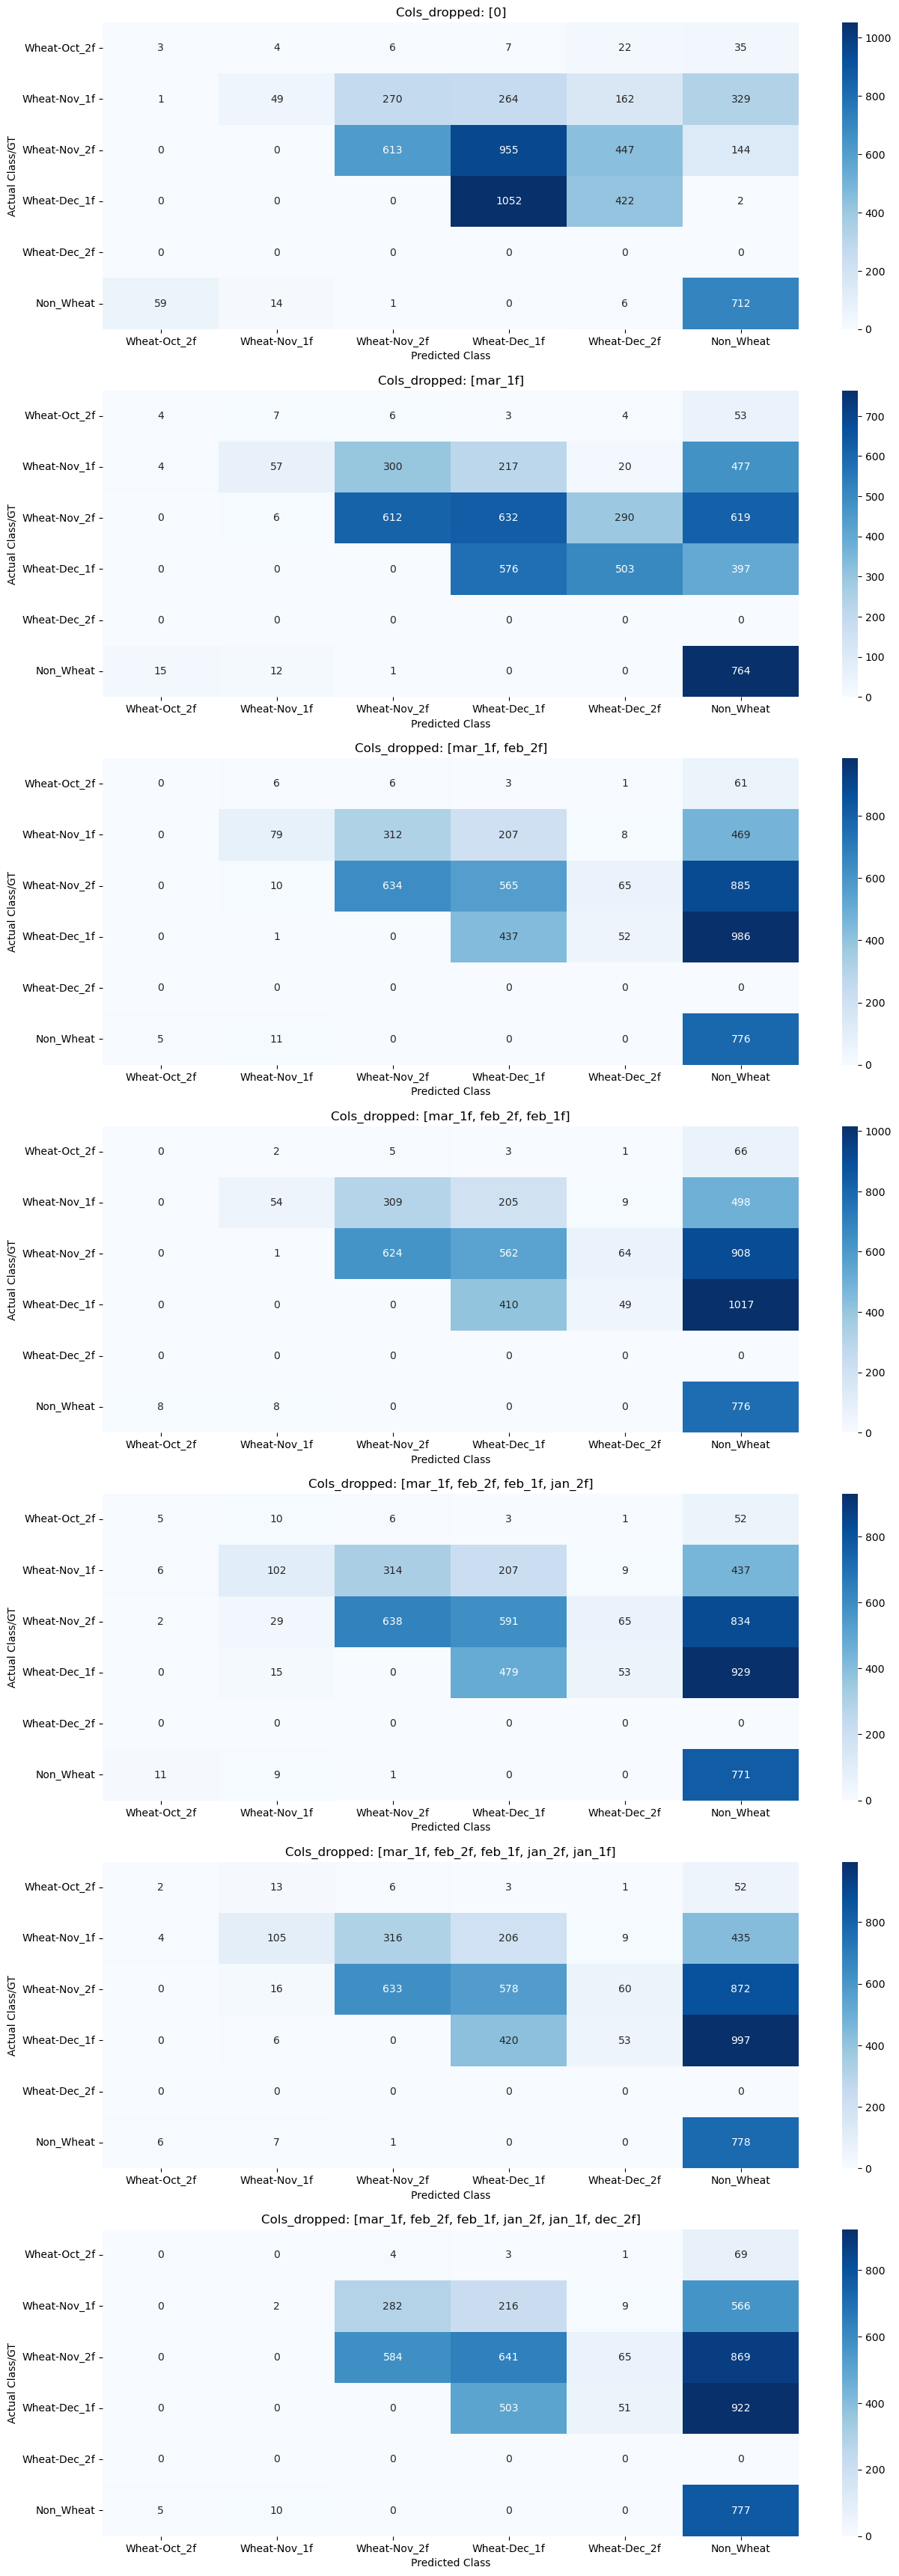

In [183]:
plt.figure(figsize=(15,50))
columns_dropped = ['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f']
for i in range(len(confusion_matrices)):
    plt.subplot(8,1,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Cols_dropped: [{columns_dropped[i]}]')
plt.show()

In [184]:
inter = set(tst_pol[(y_hat[0] & y_tst_pol) == 0].index)
for i in y_hat[1:]:
    inter = inter.intersection(set(tst_pol[(i & y_tst_pol) == 0].index))

C:\Users\user\AppData\Local\Temp\ipykernel_5616\2099886206.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inter = set(tst_pol[(y_hat[0] & y_tst_pol) == 0].index)
C:\Users\user\AppData\Local\Temp\ipykernel_5616\2099886206.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inter = inter.intersection(set(tst_pol[(i & y_tst_pol) == 0].index))
C:\Users\user\AppData\Local\Temp\ipykernel_5616\2099886206.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inter = inter.intersection(set(tst_pol[(i & y_tst_pol) == 0].index))
C:\Users\user\AppData\Local\Temp\ipykernel_5616\2099886206.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inter = inter.intersection(set(tst_pol[(i & y_tst_pol) == 0].index))
C:\Users\user\AppData\Local\Temp\ipykernel_5616\2099886206.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inter = inter.intersec

In [185]:
len(inter)

2539

C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ic = tst_pol[((y_hat[i] & y_tst_pol) == 0)]
C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corr = tst_pol[((y_hat[i] & y_tst_pol) == 1)]
C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ic = tst_pol[((y_hat[i] & y_tst_pol) == 0)]
C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corr = tst_pol[((y_hat[i] & y_tst_pol) == 1)]
C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ic = tst_pol[((y_hat[i] & y_tst_pol) == 0)]
C:\Users\user\AppData\Local\Temp\ipykernel_5616\3293208763.py

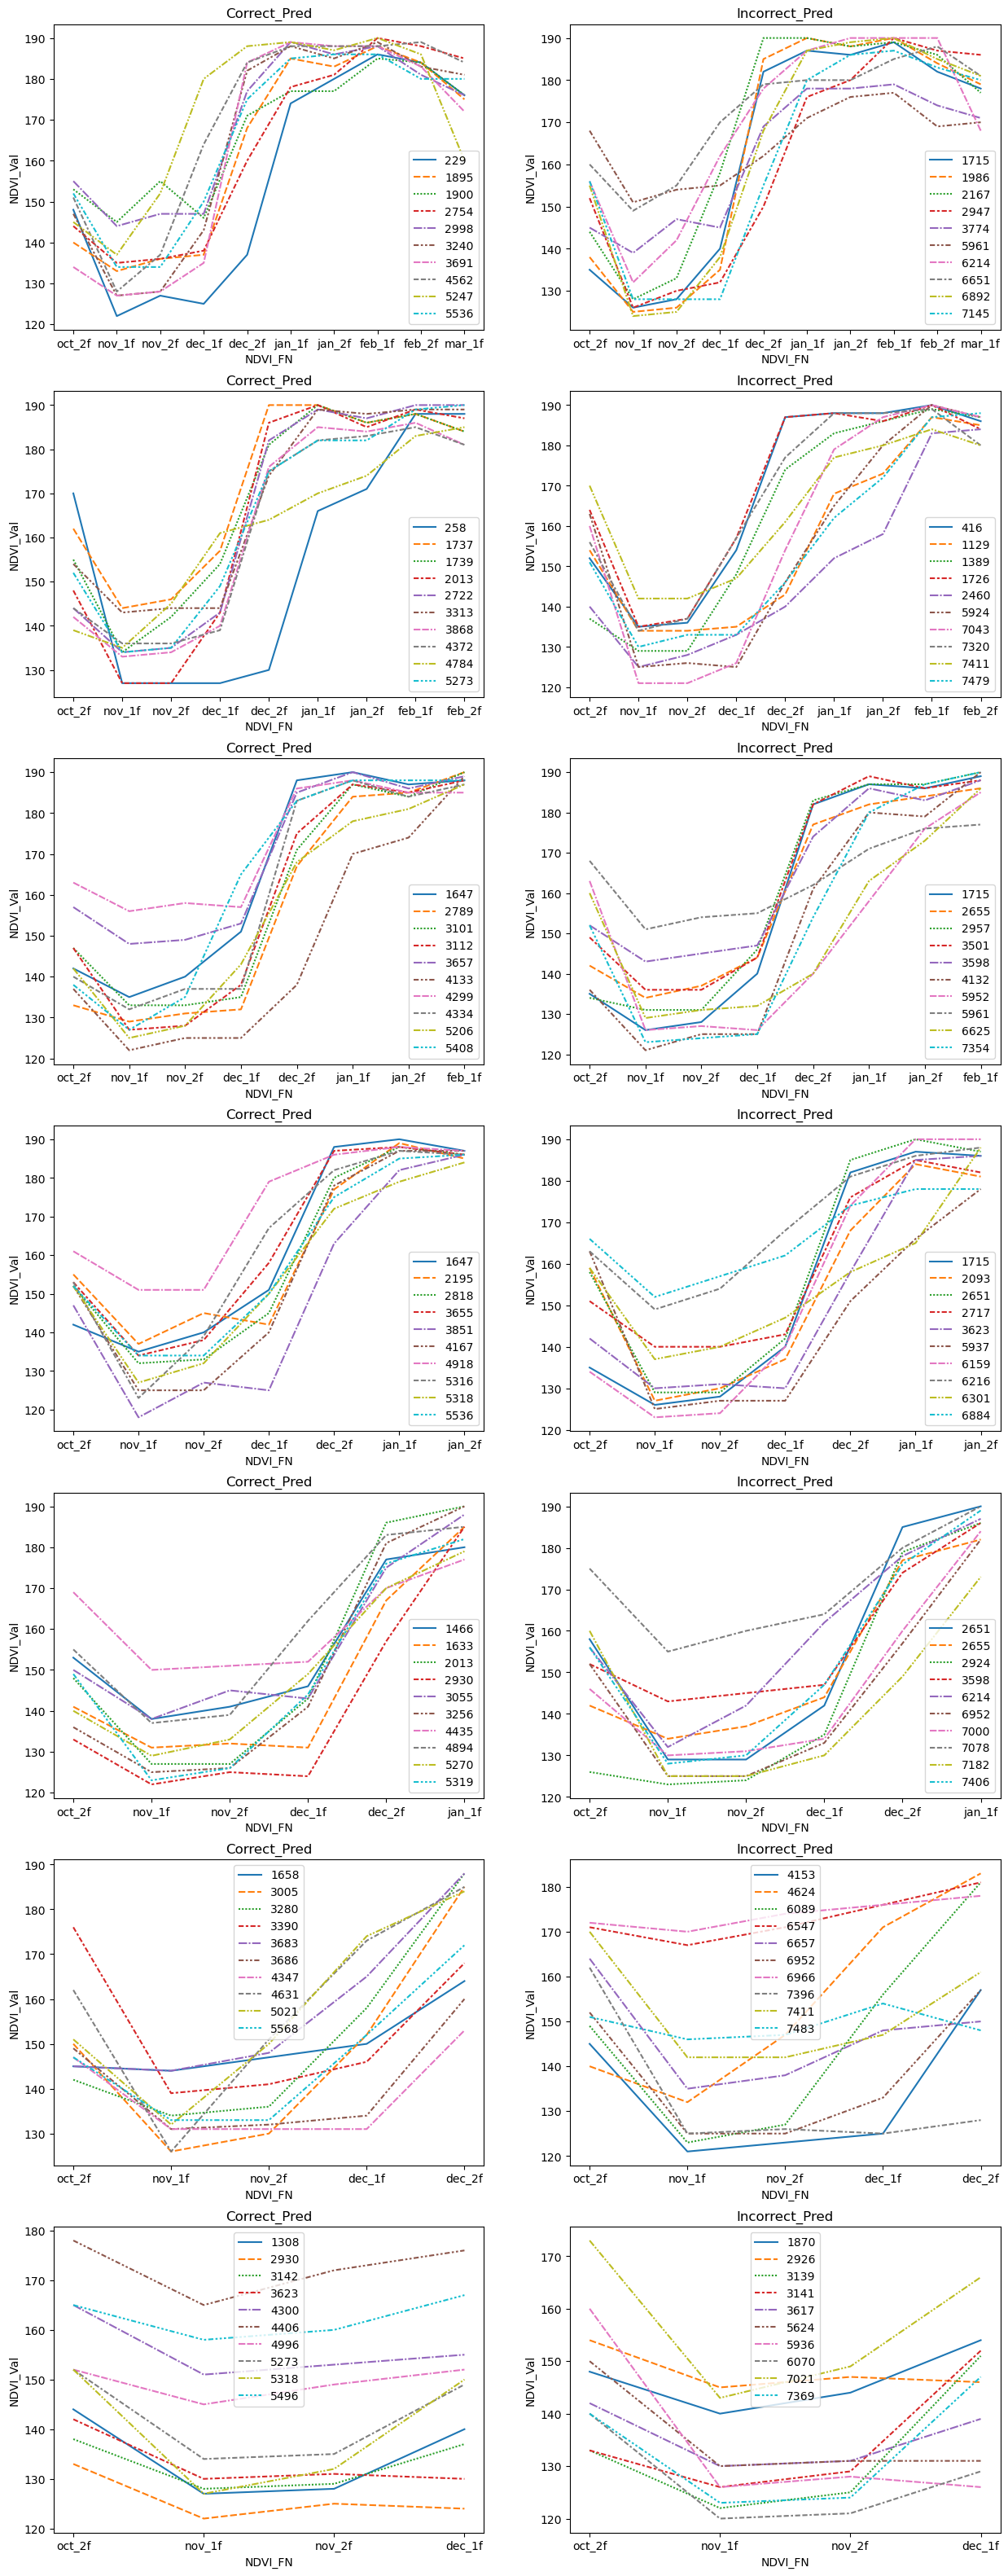

In [186]:
j = 1
plt.figure(figsize=(15,40))
for i in range(len(y_hat)):
    ic = tst_pol[((y_hat[i] & y_tst_pol) == 0)]
    corr = tst_pol[((y_hat[i] & y_tst_pol) == 1)]
    ic_ndvi_df = ic[ic.label == 1].sample(10, random_state=42).iloc[:,:-(i+1)]
    corr_ndvi_df = corr[corr.label == 1].sample(10, random_state=42).iloc[:,:-(i+1)]
    plt.subplot(7,2,j)
    sns.lineplot(corr_ndvi_df.T).set(title='Correct_Pred')
    plt.xlabel('NDVI_FN')
    plt.ylabel('NDVI_Val')
    plt.subplot(7,2,j+1)
    sns.lineplot(ic_ndvi_df.T).set(title='Incorrect_Pred')
    plt.xlabel('NDVI_FN')
    plt.ylabel('NDVI_Val')
    j += 2
plt.show()

In [187]:
from IPython.display import display

x = ['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f']

x *= 2

print("\033[1;31m" + 'New_pure_outlier_imputation')
print()
for i in range(len(test_dfs)):
    if i == 7:
        print("\033[1;31m" + 'New_pure_outlier_removal')
        print()
    print("\033[1;32m" + f'cols_dropped:[{x[i]}]')
    display(test_dfs[i])

New_pure_outlier_imputation

cols_dropped:[0]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f   274            10             3.65                    0   
Wheat-Nov_1f  2665           298            11.18                    1   
Wheat-Nov_2f  2859           949            33.19                    0   
Wheat-Dec_1f  1679          1201            71.53                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      809           727            89.86                   60   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                   28                   26                   25   
Wheat-Nov_1f                    0                  703                  375   
Wheat-Nov_2f                    0                    0                 1146   
Wheat-Dec_1f                    0                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                      15                    1                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                   40               145  
Wheat-Nov_1f                  242              1046  
Wheat-Nov_2f                  537               227  
Wheat-Dec_1f                  473                 5  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       6                 0

cols_dropped:[mar_1f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f   274            10             3.65                    0   
Wheat-Nov_1f  2665           318            11.93                    5   
Wheat-Nov_2f  2859           962            33.65                    0   
Wheat-Dec_1f  1679           665            39.61                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      809           780            96.42                   16   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                   36                   22                   10   
Wheat-Nov_1f                    0                  768                  307   
Wheat-Nov_2f                    7                    0                  775   
Wheat-Dec_1f                    0                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                      12                    1                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                   18               178  
Wheat-Nov_1f                   28              1239  
Wheat-Nov_2f                  314               801  
Wheat-Dec_1f                  546               468  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

cols_dropped:[mar_1f, feb_2f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f   274             1             0.36                    0   
Wheat-Nov_1f  2665           343            12.87                    0   
Wheat-Nov_2f  2859           995            34.80                    0   
Wheat-Dec_1f  1679           523            31.15                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      809           792            97.90                    5   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                   24                   23                   10   
Wheat-Nov_1f                    0                  782                  301   
Wheat-Nov_2f                   12                    0                  706   
Wheat-Dec_1f                    1                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                      12                    0                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                    4               212  
Wheat-Nov_1f                   11              1228  
Wheat-Nov_2f                   75              1071  
Wheat-Dec_1f                   64              1091  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

cols_dropped:[mar_1f, feb_2f, feb_1f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f   274             0             0.00                    0   
Wheat-Nov_1f  2665           269            10.09                    0   
Wheat-Nov_2f  2859           989            34.59                    0   
Wheat-Dec_1f  1679           498            29.66                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      809           792            97.90                    9   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                   15                   22                   10   
Wheat-Nov_1f                    0                  772                  299   
Wheat-Nov_2f                    1                    0                  712   
Wheat-Dec_1f                    0                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                       8                    0                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                    4               223  
Wheat-Nov_1f                   11              1314  
Wheat-Nov_2f                   74              1083  
Wheat-Dec_1f                   61              1120  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

cols_dropped:[mar_1f, feb_2f, feb_1f, jan_2f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f   274             7             2.55                    0   
Wheat-Nov_1f  2665           440            16.51                    7   
Wheat-Nov_2f  2859           998            34.91                    2   
Wheat-Dec_1f  1679           569            33.89                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      809           785            97.03                   13   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                   40                   23                   10   
Wheat-Nov_1f                    0                  795                  300   
Wheat-Nov_2f                   35                    0                  736   
Wheat-Dec_1f                   15                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                      10                    1                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                    4               190  
Wheat-Nov_1f                   12              1111  
Wheat-Nov_2f                   75              1013  
Wheat-Dec_1f                   65              1030  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

cols_dropped:[mar_1f, feb_2f, feb_1f, jan_2f, jan_1f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f   274             6             2.19                    0   
Wheat-Nov_1f  2665           521            19.55                    5   
Wheat-Nov_2f  2859           996            34.84                    0   
Wheat-Dec_1f  1679           509            30.32                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      809           793            98.02                    7   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                   43                   23                   10   
Wheat-Nov_1f                    0                  798                  300   
Wheat-Nov_2f                   18                    0                  729   
Wheat-Dec_1f                    6                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                       8                    1                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                    4               188  
Wheat-Nov_1f                   12              1029  
Wheat-Nov_2f                   70              1046  
Wheat-Dec_1f                   65              1099  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

cols_dropped:[mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f   274             0             0.00                    0   
Wheat-Nov_1f  2665             9             0.34                    0   
Wheat-Nov_2f  2859           886            30.99                    0   
Wheat-Dec_1f  1679           615            36.63                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      809           794            98.15                    5   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                    2                   12                   10   
Wheat-Nov_1f                    0                  703                  312   
Wheat-Nov_2f                    0                    0                  812   
Wheat-Dec_1f                    0                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                      10                    0                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                    4               246  
Wheat-Nov_1f                   11              1630  
Wheat-Nov_2f                   76              1085  
Wheat-Dec_1f                   64              1000  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

New_pure_outlier_removal

cols_dropped:[0]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f    77             3             3.90                    0   
Wheat-Nov_1f  1075            49             4.56                    1   
Wheat-Nov_2f  2159           613            28.39                    0   
Wheat-Dec_1f  1476          1052            71.27                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      792           712            89.90                   59   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                    4                    6                    7   
Wheat-Nov_1f                    0                  270                  264   
Wheat-Nov_2f                    0                    0                  955   
Wheat-Dec_1f                    0                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                      14                    1                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                   22                35  
Wheat-Nov_1f                  162               329  
Wheat-Nov_2f                  447               144  
Wheat-Dec_1f                  422                 2  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       6                 0

cols_dropped:[mar_1f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f    77             4             5.19                    0   
Wheat-Nov_1f  1075            57             5.30                    4   
Wheat-Nov_2f  2159           612            28.35                    0   
Wheat-Dec_1f  1476           576            39.02                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      792           764            96.46                   15   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                    7                    6                    3   
Wheat-Nov_1f                    0                  300                  217   
Wheat-Nov_2f                    6                    0                  632   
Wheat-Dec_1f                    0                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                      12                    1                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                    4                53  
Wheat-Nov_1f                   20               477  
Wheat-Nov_2f                  290               619  
Wheat-Dec_1f                  503               397  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

cols_dropped:[mar_1f, feb_2f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f    77             0             0.00                    0   
Wheat-Nov_1f  1075            79             7.35                    0   
Wheat-Nov_2f  2159           634            29.37                    0   
Wheat-Dec_1f  1476           437            29.61                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      792           776            97.98                    5   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                    6                    6                    3   
Wheat-Nov_1f                    0                  312                  207   
Wheat-Nov_2f                   10                    0                  565   
Wheat-Dec_1f                    1                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                      11                    0                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                    1                61  
Wheat-Nov_1f                    8               469  
Wheat-Nov_2f                   65               885  
Wheat-Dec_1f                   52               986  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

cols_dropped:[mar_1f, feb_2f, feb_1f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f    77             0             0.00                    0   
Wheat-Nov_1f  1075            54             5.02                    0   
Wheat-Nov_2f  2159           624            28.90                    0   
Wheat-Dec_1f  1476           410            27.78                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      792           776            97.98                    8   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                    2                    5                    3   
Wheat-Nov_1f                    0                  309                  205   
Wheat-Nov_2f                    1                    0                  562   
Wheat-Dec_1f                    0                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                       8                    0                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                    1                66  
Wheat-Nov_1f                    9               498  
Wheat-Nov_2f                   64               908  
Wheat-Dec_1f                   49              1017  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

cols_dropped:[mar_1f, feb_2f, feb_1f, jan_2f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f    77             5             6.49                    0   
Wheat-Nov_1f  1075           102             9.49                    6   
Wheat-Nov_2f  2159           638            29.55                    2   
Wheat-Dec_1f  1476           479            32.45                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      792           771            97.35                   11   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                   10                    6                    3   
Wheat-Nov_1f                    0                  314                  207   
Wheat-Nov_2f                   29                    0                  591   
Wheat-Dec_1f                   15                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                       9                    1                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                    1                52  
Wheat-Nov_1f                    9               437  
Wheat-Nov_2f                   65               834  
Wheat-Dec_1f                   53               929  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

cols_dropped:[mar_1f, feb_2f, feb_1f, jan_2f, jan_1f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f    77             2             2.60                    0   
Wheat-Nov_1f  1075           105             9.77                    4   
Wheat-Nov_2f  2159           633            29.32                    0   
Wheat-Dec_1f  1476           420            28.46                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      792           778            98.23                    6   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                   13                    6                    3   
Wheat-Nov_1f                    0                  316                  206   
Wheat-Nov_2f                   16                    0                  578   
Wheat-Dec_1f                    6                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                       7                    1                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                    1                52  
Wheat-Nov_1f                    9               435  
Wheat-Nov_2f                   60               872  
Wheat-Dec_1f                   53               997  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

cols_dropped:[mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f]


GT  correct_pred  correct_pred(%)  incorr_Wheat-Oct_2f  \
Wheat-Oct_2f    77             0             0.00                    0   
Wheat-Nov_1f  1075             2             0.19                    0   
Wheat-Nov_2f  2159           584            27.05                    0   
Wheat-Dec_1f  1476           503            34.08                    0   
Wheat-Dec_2f     0             0              NaN                    0   
Non_Wheat      792           777            98.11                    5   

              incorr_Wheat-Nov_1f  incorr_Wheat-Nov_2f  incorr_Wheat-Dec_1f  \
Wheat-Oct_2f                    0                    4                    3   
Wheat-Nov_1f                    0                  282                  216   
Wheat-Nov_2f                    0                    0                  641   
Wheat-Dec_1f                    0                    0                    0   
Wheat-Dec_2f                    0                    0                    0   
Non_Wheat                      10                    0                    0   

              incorr_Wheat-Dec_2f  incorr_Non_Wheat  
Wheat-Oct_2f                    1                69  
Wheat-Nov_1f                    9               566  
Wheat-Nov_2f                   65               869  
Wheat-Dec_1f                   51               922  
Wheat-Dec_2f                    0                 0  
Non_Wheat                       0                 0

## EDA

In [188]:
tst_pol = new_GT_initial_preprocess()

<Axes: >

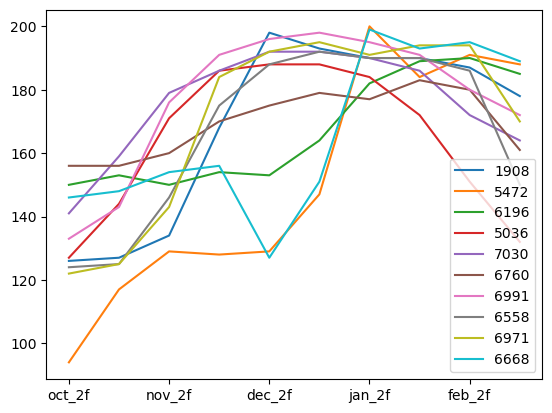

In [189]:
tst_pol[tst_pol.label == 0].iloc[:,:-1].sample(10, random_state=42).T.plot()

<Axes: >

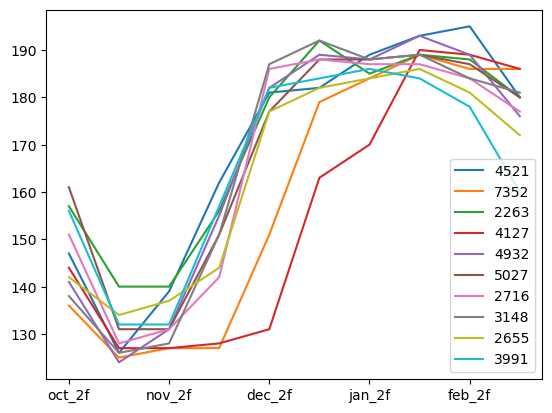

In [190]:
tst_pol[tst_pol.label == 1].iloc[:,:-1].sample(10, random_state=42).T.plot()

<Axes: >

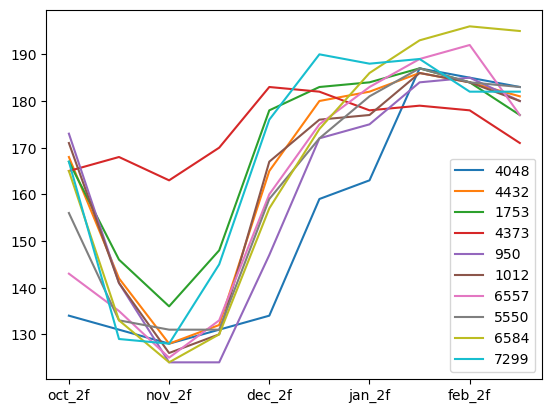

In [191]:
tst_pol[tst_pol.label == 2].iloc[:,:-1].sample(10, random_state=42).T.plot()